# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [17]:
# Code Here
import pandas as pd
import numpy as np
import random
from plotnine import *
from palmerpenguins import load_penguins
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


# Set seed for reproducibility
np.random.seed(123)
random.seed(123)

df = load_penguins()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [18]:
# Handling missing data by dropping rows with missing values
df = df.dropna()

# Separating features and target variable
X = df.drop(columns='bill_depth_mm')
y = df['bill_depth_mm']

# Identifying categorical and numerical features
lr_categorical_features = ['species']
categorical_features = ['species', 'island', 'sex', 'year']
numerical_features = ['bill_length_mm', 'flipper_length_mm', 'body_mass_g']

# Preprocessors using ColumnTransformer
lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output = False, drop='first'), lr_categorical_features)
    ]
).set_output(transform="pandas")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output = False, drop='first'), categorical_features)
    ]
).set_output(transform="pandas")

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

 ## In the following code, I do not fit on the entire dataset. I fit on a training subset, thus generating train and test error. 

In [19]:
# Creating pipelines for each model
lr_pipeline = Pipeline([
    ('preprocessor', lr_preprocessor),
    ('regressor', LinearRegression())
])

knn_pipeline_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=3))
])

knn_pipeline_5 = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 2, random_state=123))
])

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fitting and evaluating each model using the pipelines
pipelines = {
    'Linear Regression': lr_pipeline,
    'kNN (k=3)': knn_pipeline_3,
    'kNN (k=5)': knn_pipeline_5,
    'Decision Tree': tree_pipeline
}

train_errors = []
test_errors = []

for model_name, pipeline in pipelines.items():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Calculate training and test errors
    train_error = mean_squared_error(y_train, pipeline.predict(X_train))
    test_error = mean_squared_error(y_test, pipeline.predict(X_test))
    
    # Store errors
    train_errors.append(train_error)
    test_errors.append(test_error)

    print(f"{model_name} - Training Error: {train_error:.4f}, Test Error: {test_error:.4f}")

Linear Regression - Training Error: 0.6454, Test Error: 0.8471
kNN (k=3) - Training Error: 0.3799, Test Error: 0.7753
kNN (k=5) - Training Error: 0.4481, Test Error: 0.7648
Decision Tree - Training Error: 0.3588, Test Error: 0.9361


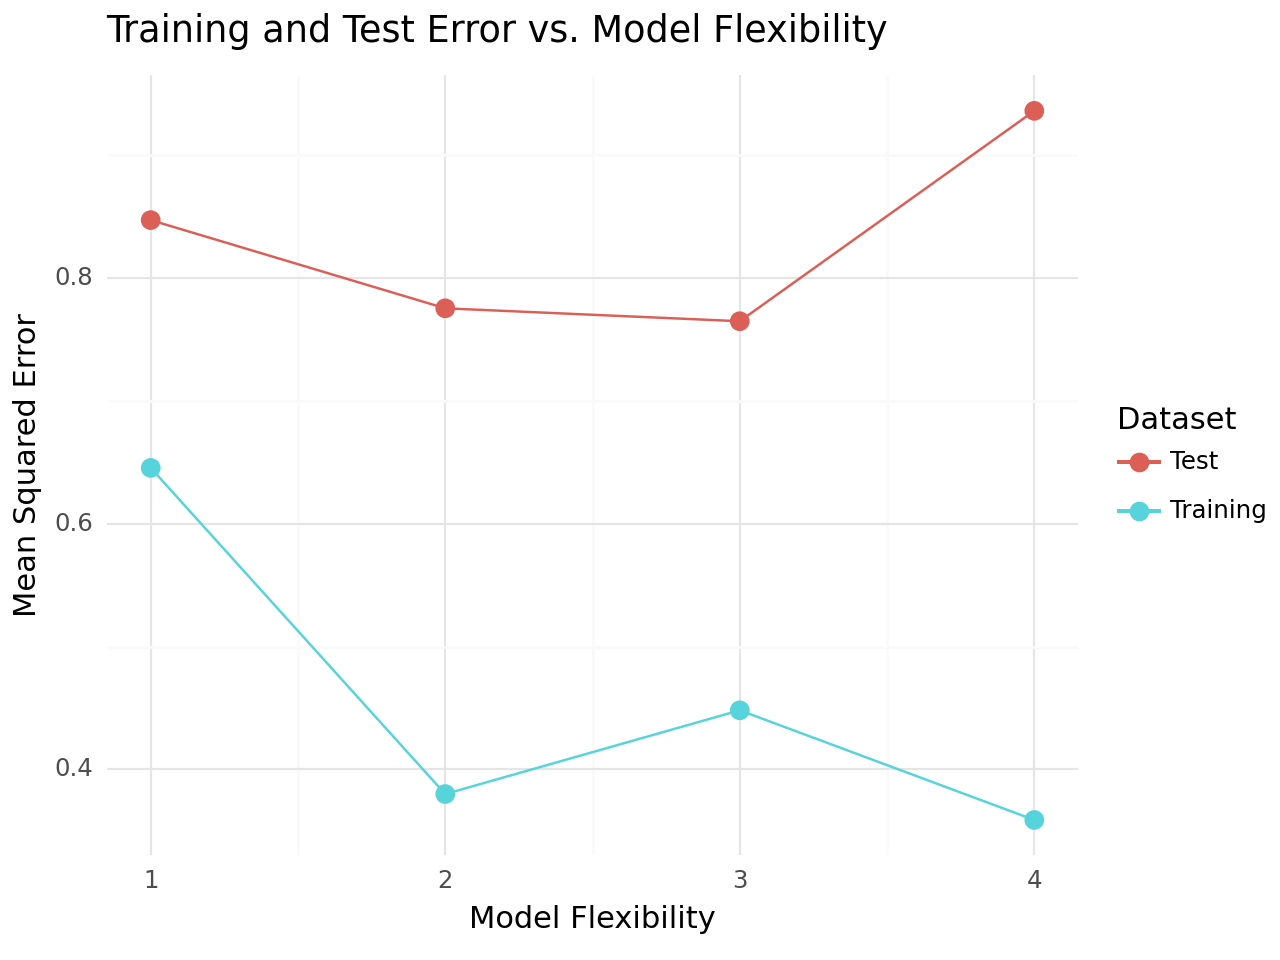

In [20]:
model_names = ['Linear Regression', 'kNN (k=3)', 'kNN (k=5)', 'Decision Tree']
model_flexibility = list(range(1, len(model_names) + 1))

# Creating a DataFrame for the plot data
error_data = pd.DataFrame({
    'Model Flexibility': model_flexibility * 2,  # Duplicates for training and test data
    'Mean Squared Error': train_errors + test_errors,
    'Dataset': ['Training'] * len(train_errors) + ['Test'] * len(test_errors)
})

# Creating the plot
plot = (
    ggplot(error_data, aes(x='Model Flexibility', y='Mean Squared Error', color='Dataset')) +
    geom_line(aes(group='Dataset')) +
    geom_point(size=3) +
    labs(title='Training and Test Error vs. Model Flexibility',
         x='Model Flexibility',
         y='Mean Squared Error') +
    theme_minimal()
)

# Display the plot
print(plot)

 The plot and results above illustrate the trade-off between bias and variance in different modeling approaches. The linear regression model exhibits relatively high training and test errors, indicating a lower complexity model that potentially underfits the data. This is typical for linear models when the relationship between predictors and the target variable is not strictly linear. On the other hand, the k-Nearest Neighbors (kNN) models, particularly with k=5, show lower test errors compared to the linear regression model, indicating better generalization performance. The reduction in training error as k increases suggests a smoother, less flexible model that captures broader patterns without overfitting. The decision tree, however, demonstrates good fitting on the training set (small error), which is a classic case of overfitting. The significantly higher test error reflects poor generalization to unseen data due to the model's excessive complexity, capturing noise in the training set rather than underlying patterns. 